In [1]:
%pip install wfdb --quiet

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import wfdb
import requests
import io
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [5]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [6]:
def download_physionet_data(record_name, database):
    if os.path.exists(f"{record_name}.dat") and os.path.exists(f"{record_name}.hea"):
        print(f"{record_name} dosyası zaten mevcut, indirmeye gerek yok.")
        return

    print(f"{record_name} kaydı indiriliyor...")

    try:
        header_url = f"https://physionet.org/files/{database}/1.0.0/{record_name}.hea"
        header_response = requests.get(header_url)

        if header_response.status_code != 200:
            print(f"Header dosyası indirilemedi: {header_response.status_code}")
            return

        with open(f"{record_name}.hea", 'wb') as f:
            f.write(header_response.content)

        data_url = f"https://physionet.org/files/{database}/1.0.0/{record_name}.dat"
        data_response = requests.get(data_url)

        if data_response.status_code != 200:
            print(f"Veri dosyası indirilemedi: {data_response.status_code}")
            return

        with open(f"{record_name}.dat", 'wb') as f:
            f.write(data_response.content)

        ann_url = f"https://physionet.org/files/{database}/1.0.0/{record_name}.atr"
        ann_response = requests.get(ann_url)

        if ann_response.status_code == 200:
            with open(f"{record_name}.atr", 'wb') as f:
                f.write(ann_response.content)

        print(f"{record_name} başarıyla indirildi.")
    except Exception as e:
        print(f"Veri indirme hatası: {e}")


In [7]:
normal_record = "16265"
normal_db = "nsrdb"
download_physionet_data(normal_record, normal_db)

abnormal_record = "100"
abnormal_db = "mitdb"
download_physionet_data(abnormal_record, abnormal_db)

16265 dosyası zaten mevcut, indirmeye gerek yok.
100 dosyası zaten mevcut, indirmeye gerek yok.


In [8]:
def analyze_ecg(record_name, title, start=0, duration=10):
    print(f"\n{title} EKG Analizi")
    print("-" * 40)

    try:
        record = wfdb.rdrecord(record_name, sampfrom=start, sampto=start + int(duration * 1000))
        annotation = wfdb.rdann(record_name, 'atr', sampfrom=start, sampto=start + int(duration * 1000)) if os.path.exists(f"{record_name}.atr") else None

        fs = record.fs
        signal_length = record.sig_len
        duration_seconds = signal_length / fs

        print(f"Örnekleme Frekansı (Fs): {fs} Hz")
        print(f"Sinyal Uzunluğu: {signal_length} örnek")
        print(f"Süre: {duration_seconds:.2f} saniye")
        print(f"Kanal Sayısı: {record.n_sig}")
        print(f"Kanal İsimleri: {record.sig_name}")

        channel = 0
        ecg_signal = record.p_signal[:, channel]
        time = np.arange(len(ecg_signal)) / fs
        plt.figure()


        plt.plot(time, ecg_signal)
        plt.title(f"{title} EKG - Zaman Domeni")
        plt.xlabel('Zaman (s)')
        plt.ylabel('Genlik (mV)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{record_name}_time_domain.png")

        n = len(ecg_signal)
        ecg_fft = fft(ecg_signal)
        xf = fftfreq(n, 1/fs)

        plt.figure()
        plt.plot(xf[:n//2], 2.0/n * np.abs(ecg_fft[:n//2]))
        plt.title(f"{title} EKG - Frekans Domeni (FFT)")
        plt.xlabel('Frekans (Hz)')
        plt.ylabel('Genlik')
        plt.grid(True)
        plt.xlim(0, 50)
        plt.tight_layout()
        plt.savefig(f"{record_name}_fft.png")

        f, Pxx = signal.welch(ecg_signal, fs, nperseg=1024)

        plt.figure()
        plt.semilogy(f, Pxx)
        plt.title(f"{title} EKG - Güç Yoğunluk Spektrumu")
        plt.xlabel('Frekans (Hz)')
        plt.ylabel('Güç/Frekans (dB/Hz)')
        plt.grid(True)
        plt.xlim(0, 50)
        plt.tight_layout()
        plt.savefig(f"{record_name}_psd.png")

        sos_high = signal.butter(5, 0.5, 'hp', fs=fs, output='sos')
        ecg_filtered_baseline = signal.sosfilt(sos_high, ecg_signal)

        notch_b, notch_a = signal.iirnotch(50, 30, fs)
        ecg_filtered = signal.filtfilt(notch_b, notch_a, ecg_filtered_baseline)

        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(time, ecg_signal)
        plt.title(f"{title} EKG - Filtrelenmemiş")
        plt.xlabel('Zaman (s)')
        plt.ylabel('Genlik (mV)')
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.plot(time, ecg_filtered)
        plt.title(f"{title} EKG - Filtrelenmiş (Taban Çizgisi + 50 Hz Şebeke)")
        plt.xlabel('Zaman (s)')
        plt.ylabel('Genlik (mV)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{record_name}_filtered.png")

        ecg_filtered_fft = fft(ecg_filtered)

        plt.figure()
        plt.plot(xf[:n//2], 2.0/n * np.abs(ecg_fft[:n//2]), label='Filtrelenmemiş')
        plt.plot(xf[:n//2], 2.0/n * np.abs(ecg_filtered_fft[:n//2]), label='Filtrelenmiş')
        plt.title(f"{title} EKG - Frekans Domeni Karşılaştırma")
        plt.xlabel('Frekans (Hz)')
        plt.ylabel('Genlik')
        plt.grid(True)
        plt.xlim(0, 50)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{record_name}_fft_comparison.png")

        f_filtered, Pxx_filtered = signal.welch(ecg_filtered, fs, nperseg=1024)

        plt.figure()
        plt.semilogy(f, Pxx, label='Filtrelenmemiş')
        plt.semilogy(f_filtered, Pxx_filtered, label='Filtrelenmiş')
        plt.title(f"{title} EKG - Güç Yoğunluk Spektrumu Karşılaştırma")
        plt.xlabel('Frekans (Hz)')
        plt.ylabel('Güç/Frekans (dB/Hz)')
        plt.grid(True)
        plt.xlim(0, 50)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{record_name}_psd_comparison.png")

        return ecg_signal, ecg_filtered, fs
    except Exception as e:
        print(f"Hata: {e}")
        return None, None, None



Normal EKG Analizi
----------------------------------------
Örnekleme Frekansı (Fs): 128 Hz
Sinyal Uzunluğu: 10000 örnek
Süre: 78.12 saniye
Kanal Sayısı: 2
Kanal İsimleri: ['ECG1', 'ECG2']

Aritmi (Kalp Ritim Bozukluğu) EKG Analizi
----------------------------------------
Örnekleme Frekansı (Fs): 360 Hz
Sinyal Uzunluğu: 10000 örnek
Süre: 27.78 saniye
Kanal Sayısı: 2
Kanal İsimleri: ['MLII', 'V5']

Analiz tamamlandı. Tüm grafikler kaydedildi.


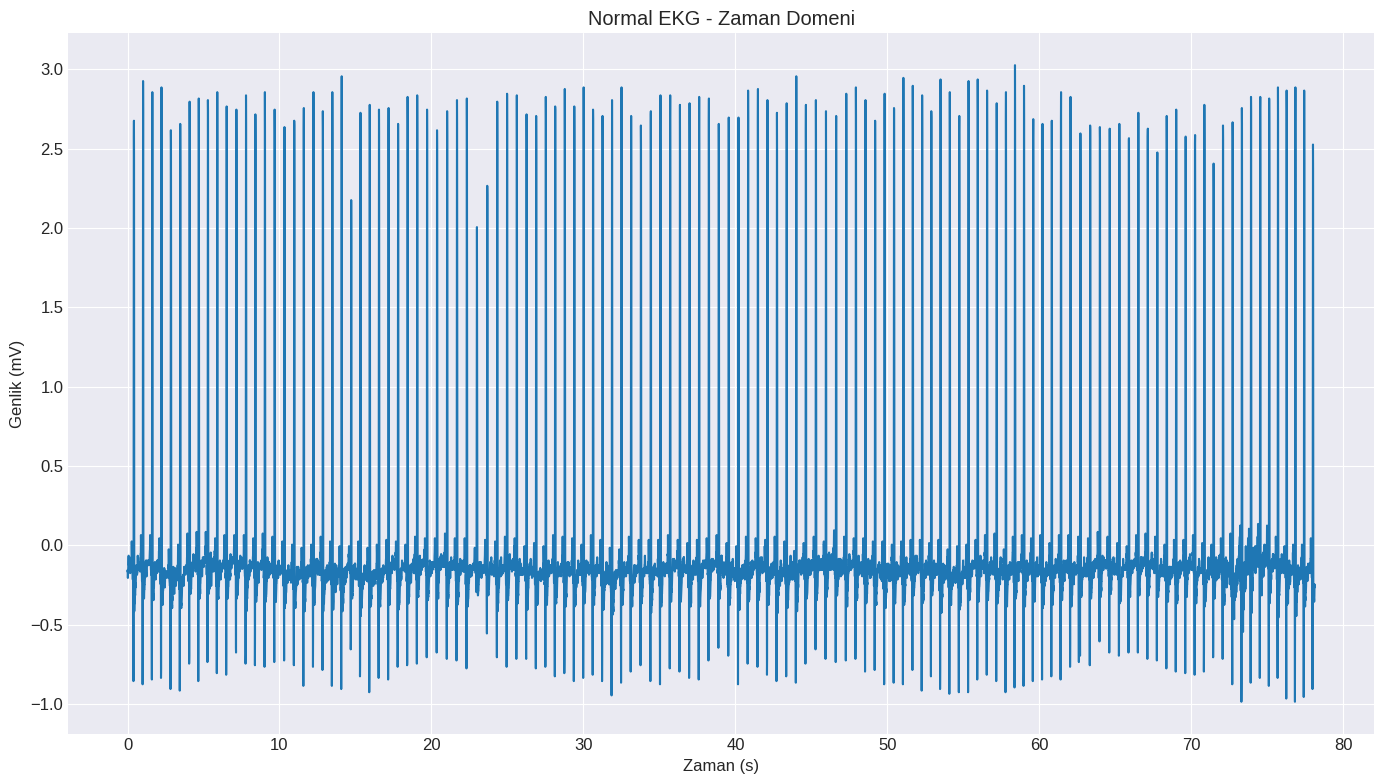

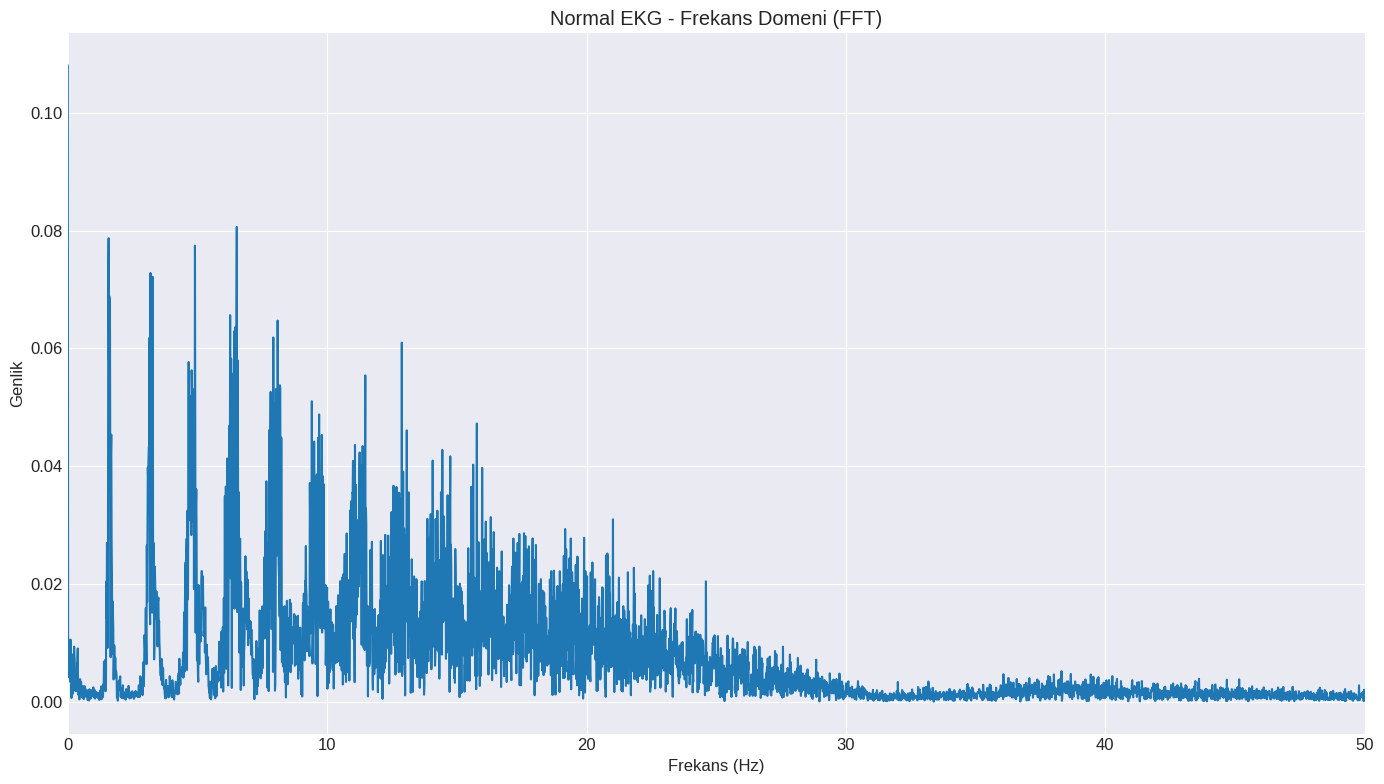

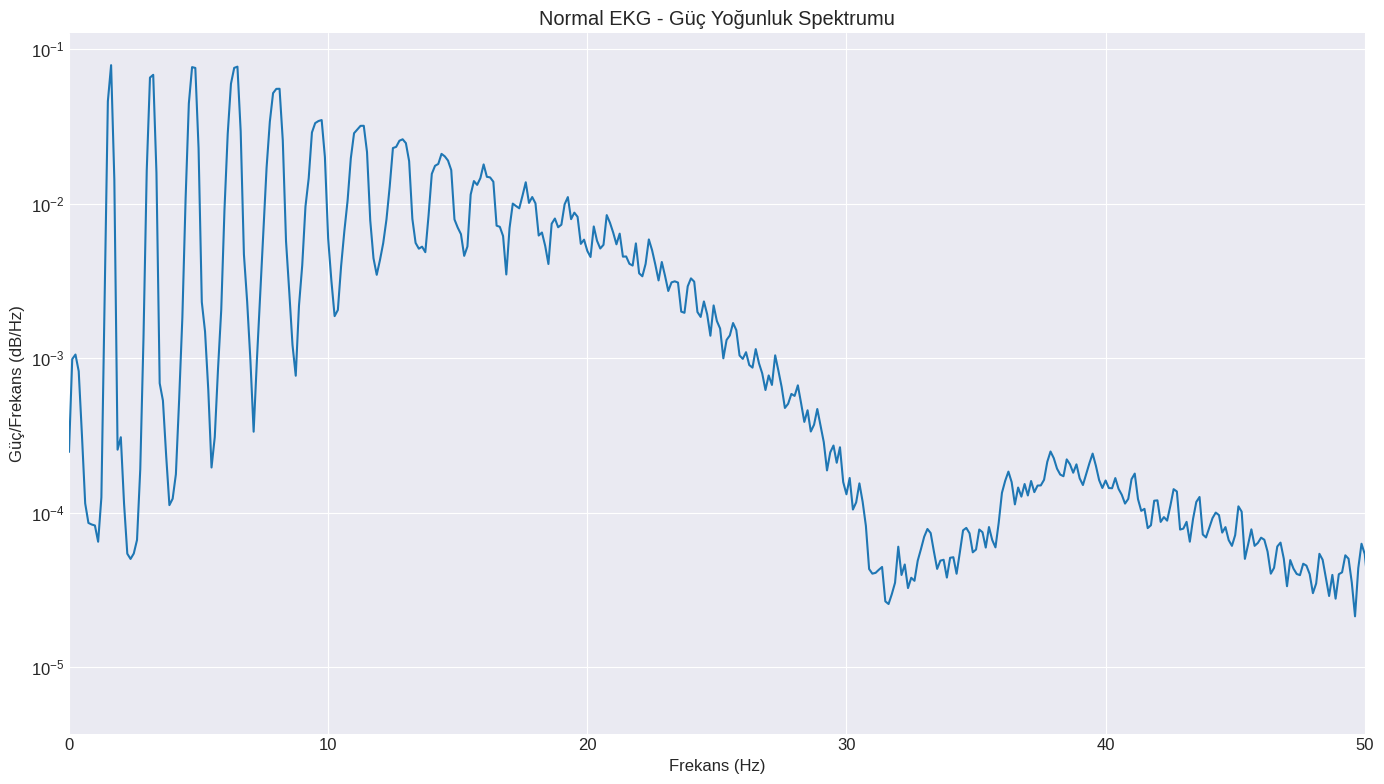

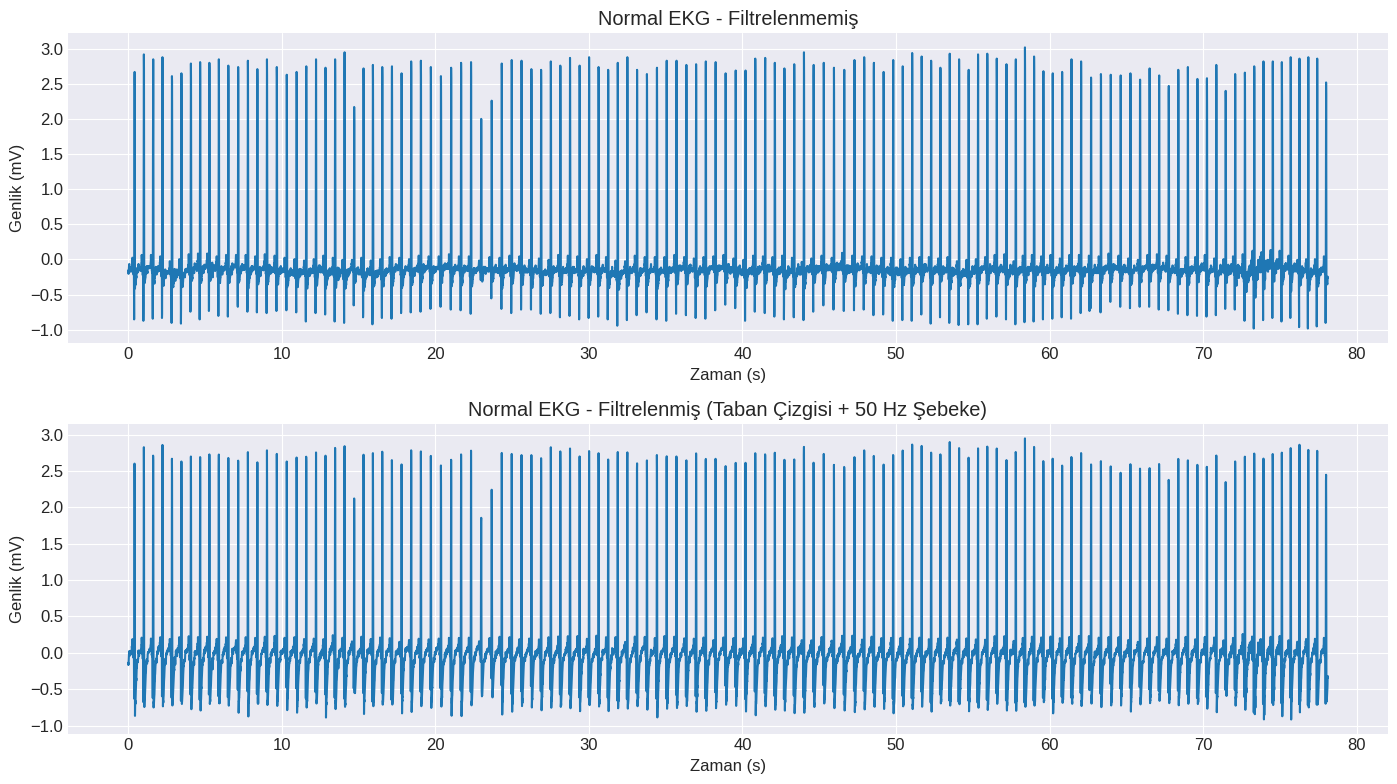

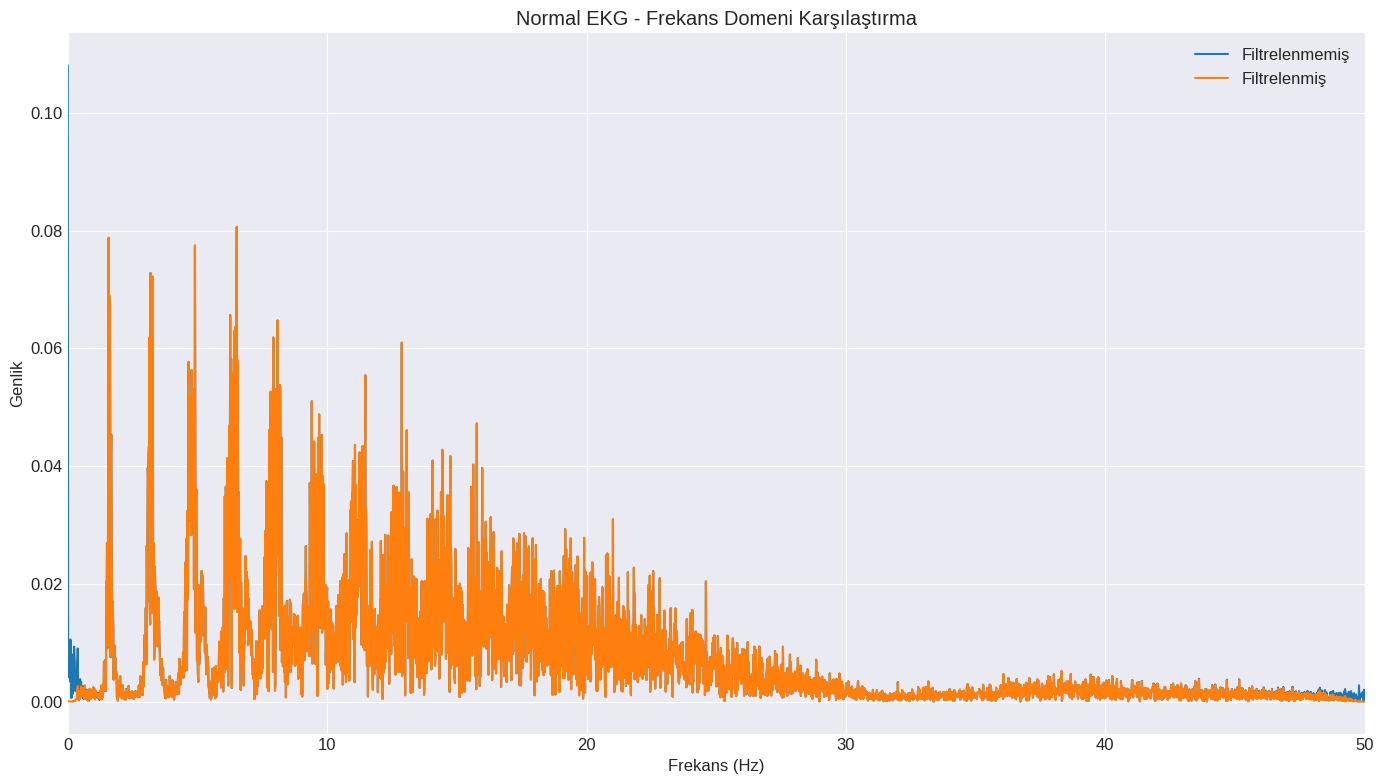

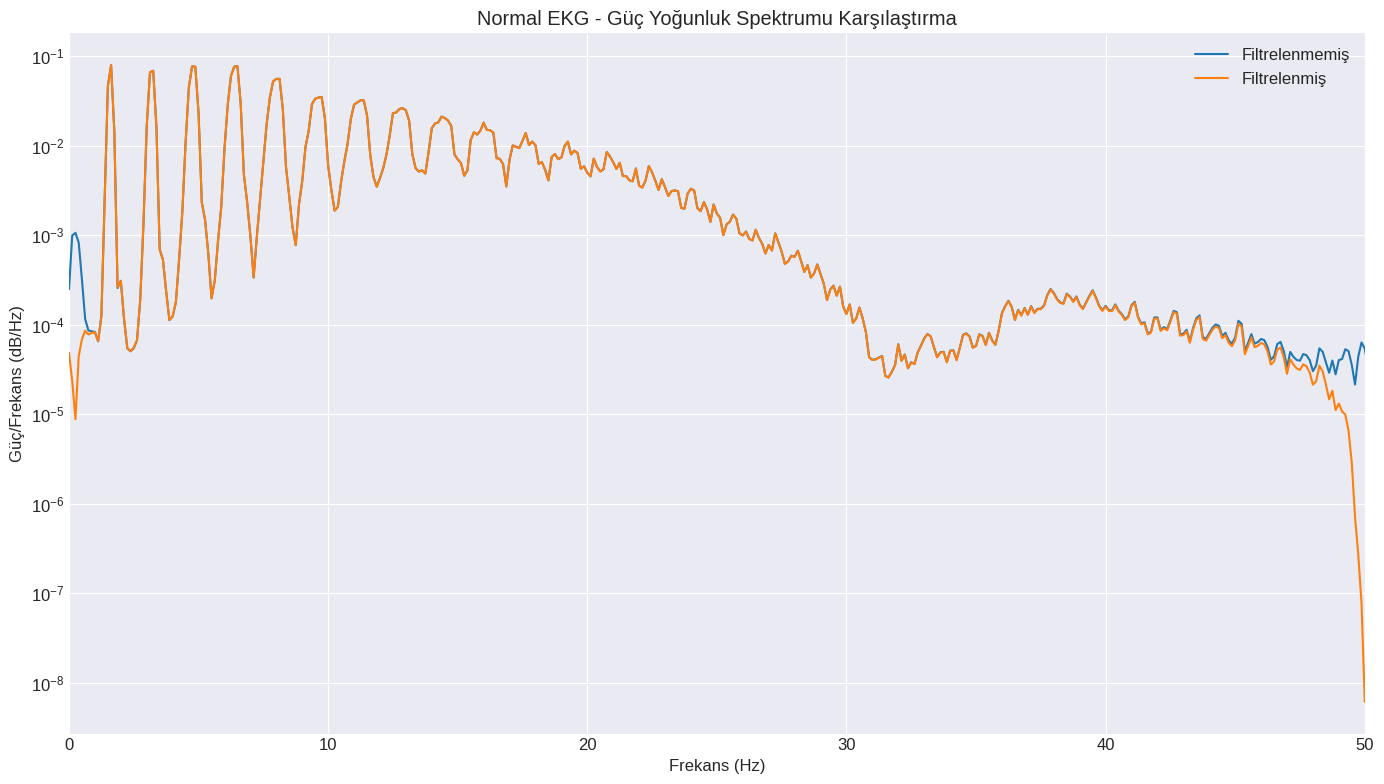

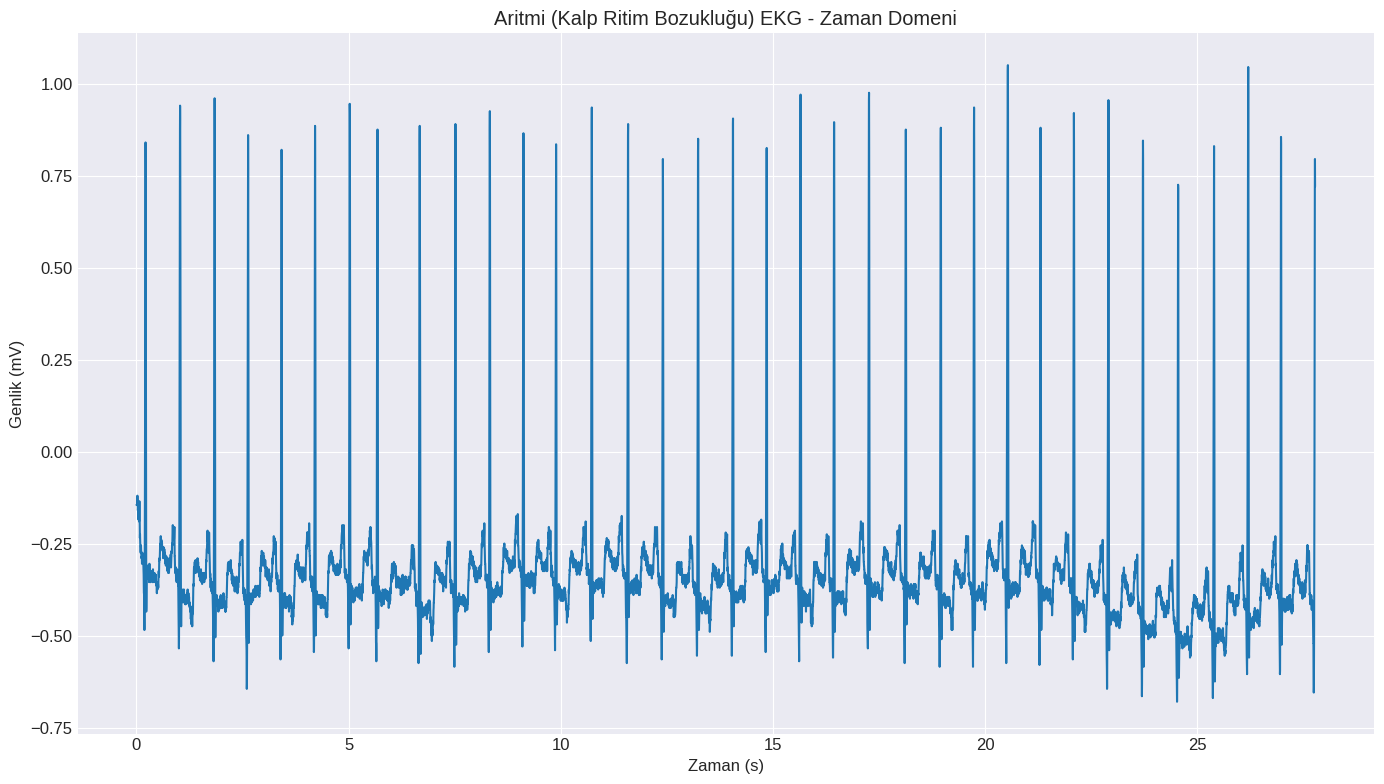

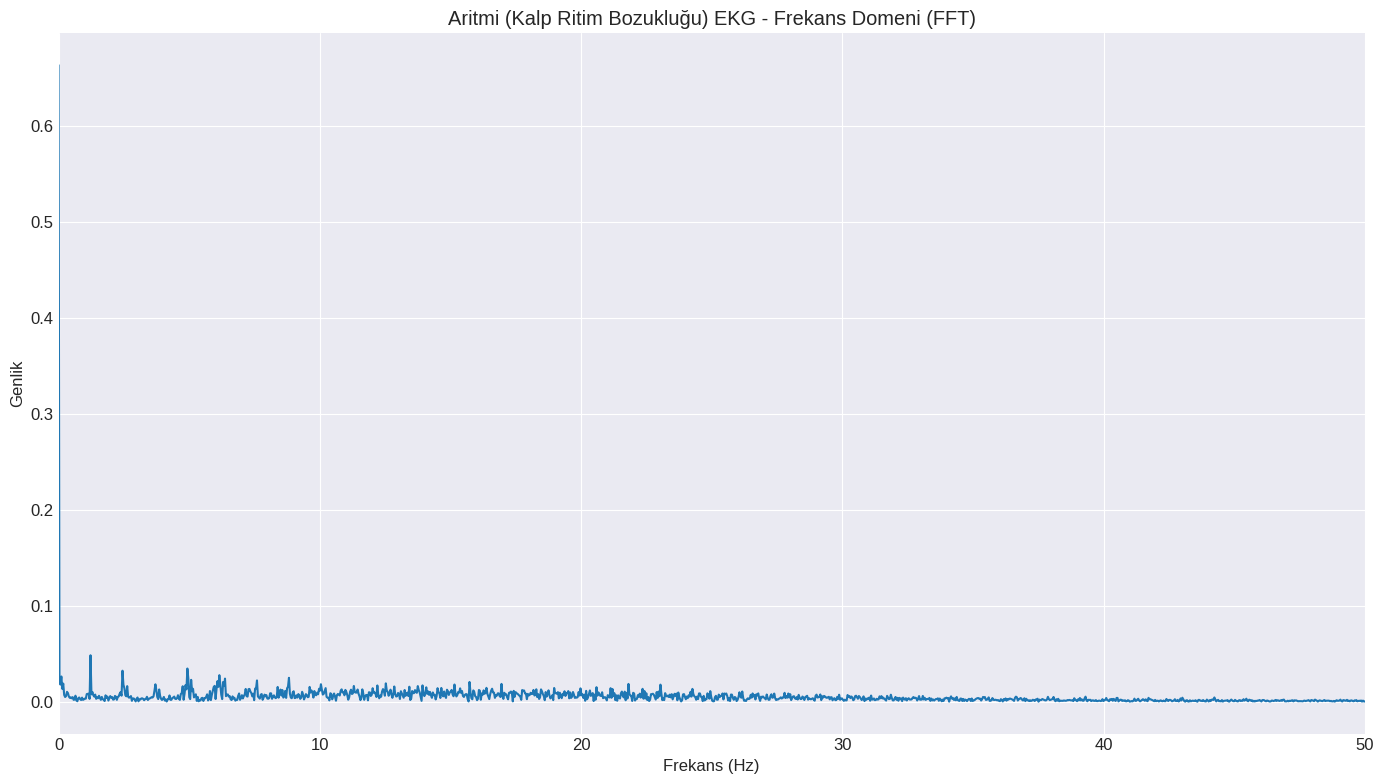

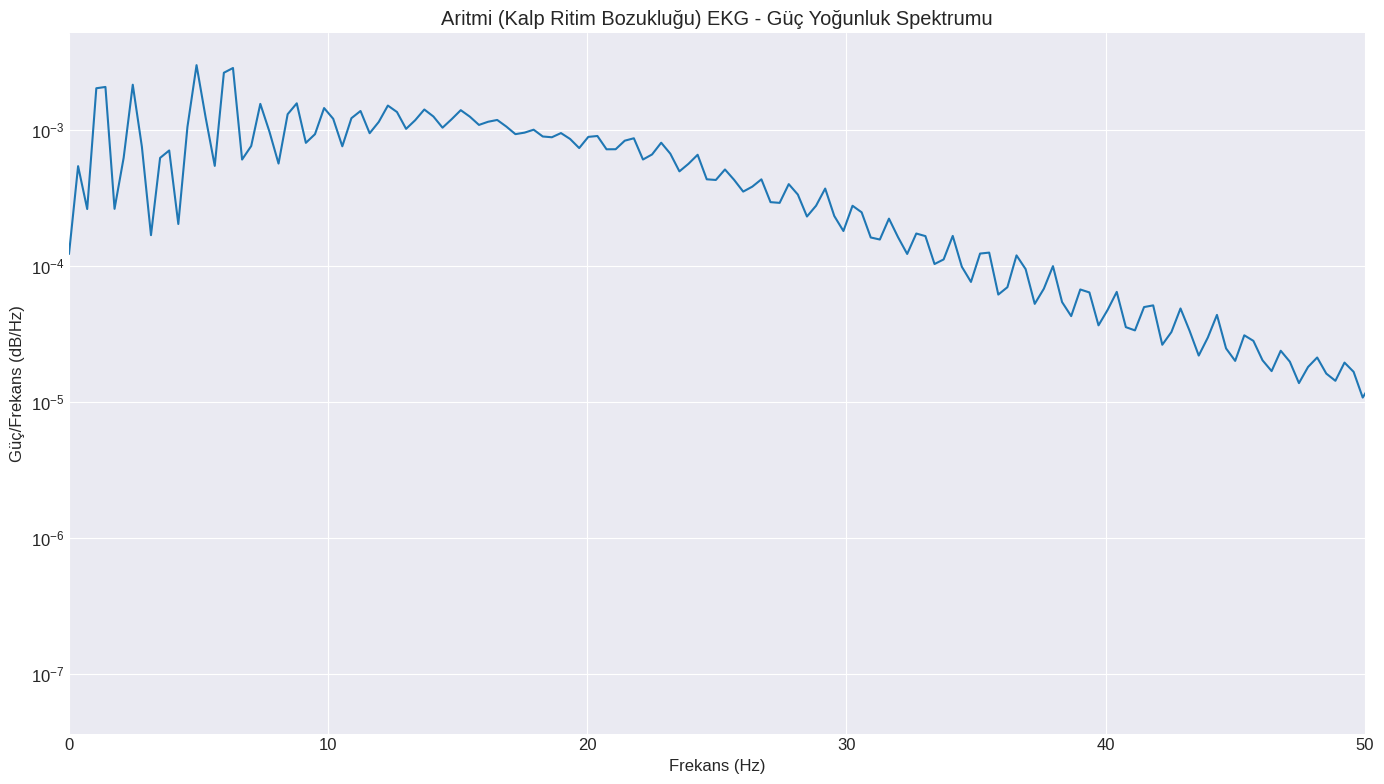

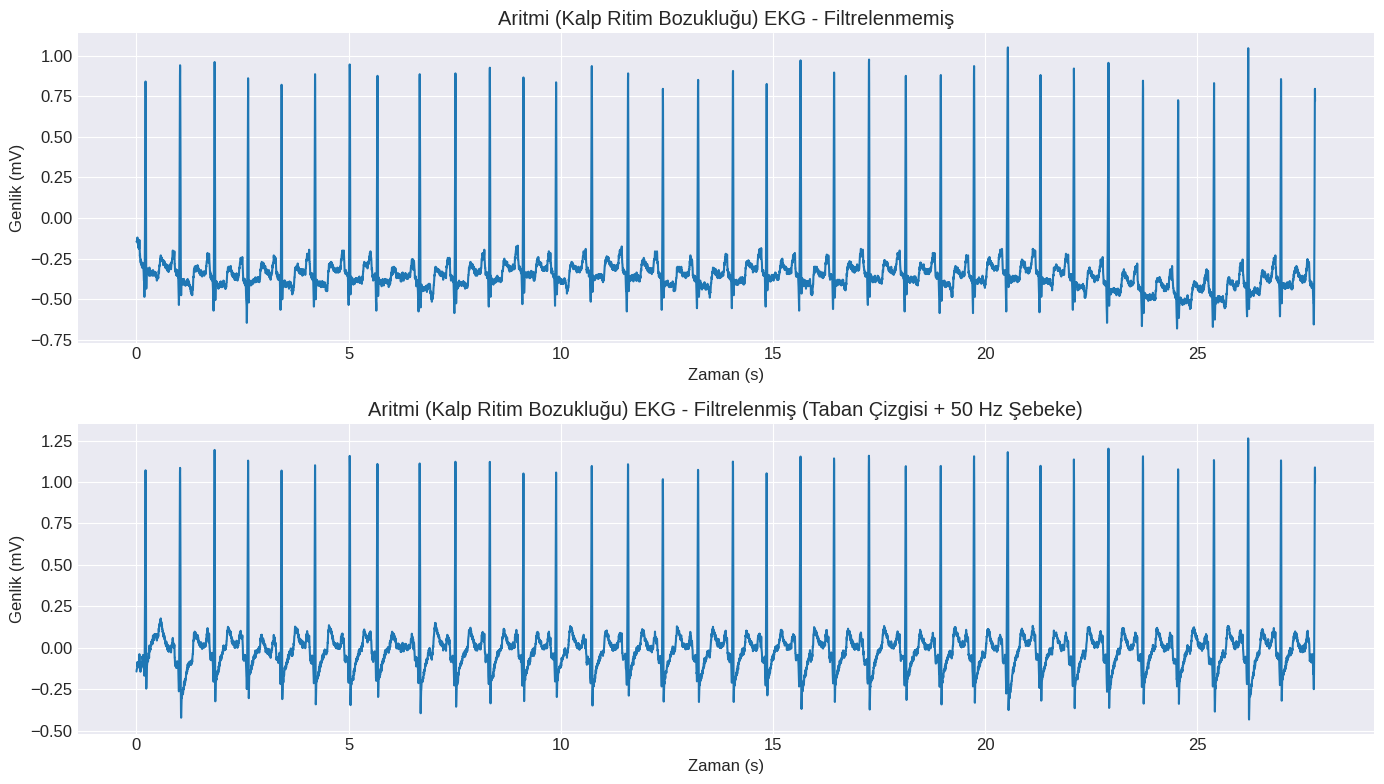

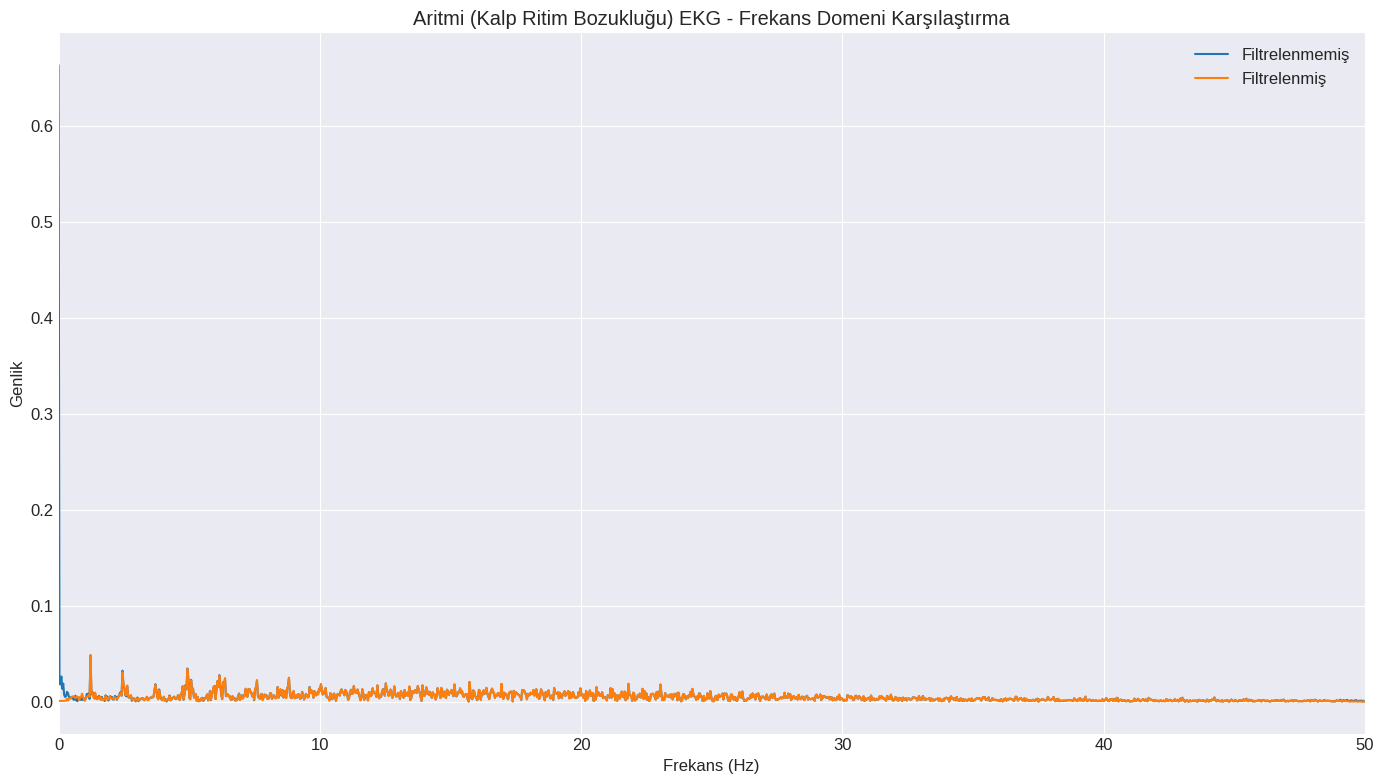

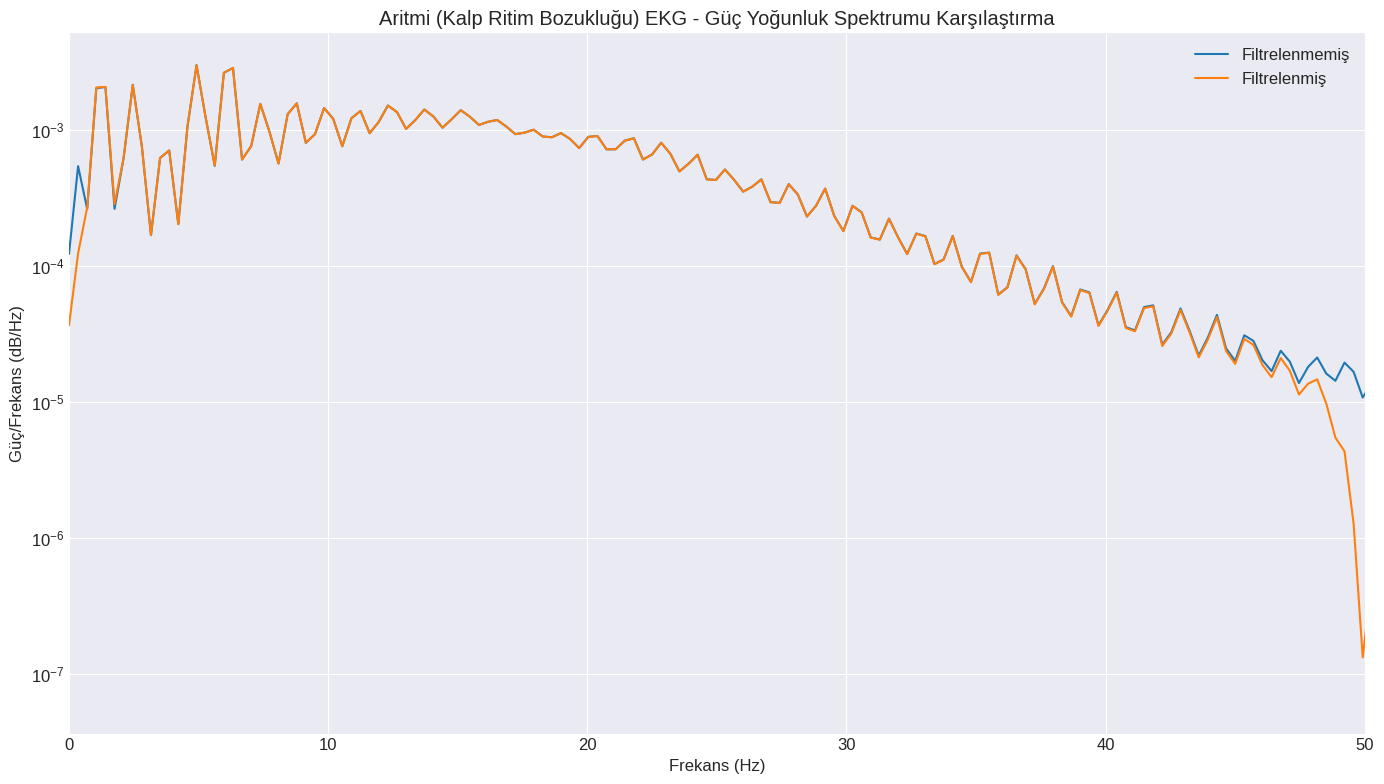

In [9]:
normal_signal, normal_filtered, normal_fs = analyze_ecg(normal_record, "Normal")
abnormal_signal, abnormal_filtered, abnormal_fs = analyze_ecg(abnormal_record, "Aritmi (Kalp Ritim Bozukluğu)")

print("\nAnaliz tamamlandı. Tüm grafikler kaydedildi.")